# _Kinetics of Reactions_ ( _Kinexns_ )

## 1. Building and solving the chemical kinetic model from chemkin input files

In [2]:
import sys, os
import matplotlib.pyplot as plt
sys.path.append("/Users/prguser/Documents/kinexns")

from kinexns.ode_builder import *
from kinexns.ode_solver import *
from kinexns.parse_chemkin import *

Could not find GLIMDA.


setting up the paths for the input files

In [3]:
cwd = os.getcwd()

file_thermo, file_smiles, file_reaction = set_paths_chemkin_files(cwd)
file_thermo

'/Users/prguser/Documents/kinexns/Notebooks/example_chemkin/data/thermo.dat'

__What are these files? Lets Look at the reaction file first__

<img src = 'images/reaction.png' style = 'height:600px;width:600px'/> 



__Now the thermo and smiles files__

<img src = 'images/thermo.png' style = 'height:600px;width:500px'/> 
<img src = 'images/smiles.png' style = 'height:600px;width:200px'/> 

__Firstly, create a dictionary of all the species with their smiles__

In [4]:
smiles_dict = generate_smile_dict_chemkin(file_smiles)
first5smiles = {k: smiles_dict[k] for k in list(smiles_dict)[:5]}
first5smiles

{'N2': 'N#N', 'AR': '[Ar]', 'HE': '[He]', 'H': '[H]', 'O2': 'O=O'}

__Additionally, we can generate a dictionary of thermodynamic properties for all the 
species at a given temperature__

In [8]:
temp = 950
thermo_dict =  generate_thermo_dict(file_thermo, smiles_dict, temp)
first5thermo = {k: thermo_dict[k] for k in list(thermo_dict)[:5]}
first5thermo

{'N#N': [32.49308410536418,
  19837.280954717462,
  226.40234513035506,
  -195244.94691911986],
 '[Ar]': [20.785, 13548.702250000002, 178.81048634979848, -156321.25978230857],
 '[He]': [20.785, 13548.702250000002, 150.2329734696345, -129172.62254615276],
 '[H]': [20.784999991659948,
  231533.75843199072,
  138.7978410407275,
  99675.8094432996],
 'O=O': [34.663968430292556,
  20966.875816210275,
  241.7892436524801,
  -208732.9056536458]}

The four values in the values fot each key represents a list of speciefic heat,
enthalpy, entropy and free energy of that epecies at the given temperature

__Finally, we need to parse the chemkin reaction file to get the following things done__

1. Write the reactions in a specific format to a file that can be recognized by *kinexns*
2. Write the Arrhenius rate parameters in a specific format to a file that can be recognized by *kinexns*
3. Get the third body efficiency and pressure dependence reactions and associated parameters

In [6]:
# Supply the names of the files to be written
file_reaction_list = cwd + '/data/complete_reaction_list.dat'
file_rateconstant_list = cwd + '/data/complete_rateconstant_list.dat'

In [10]:
# Get all the informations from the chemkin reaction files using a single function

data_from_chemkin = parse_chemkin_reaction(file_reaction, smiles_dict, file_reaction_list, file_rateconstant_list)

# data_from_chemkin contains information related to three body efficiency and pressure dependence
# first entry lists all the reactions those have third body efficiency
# second entry lists all the related three body efficiency paremeters
# third entry is a list of lists which contains a. a list of pressure dependent reactions
# b. fall off reaction parameters and c. troe parameters

__Now, we have all the files in the required format__

Its time to create some additional variables required to build the model

In [11]:
# reac_prod_list = A list of reactants and products with their stoichiometric ratios
# speciesindices = a dictionary where the key is the species smiles and 
# value is the number to represent the species
# unique_species = a list of unique species present in the mechanism

reac_prod_list, speciesindices, unique_species = build_species_list(file_reaction_list)
first5species = {k: speciesindices[k] for k in list(speciesindices)[:5]}
first5species

# indices_to_species = dict(zip(speciesindices.values(), speciesindices.keys()))


{'C': 0, 'C#C': 1, 'C#C[O]': 2, 'C#[C]': 3, 'C(OO)C=O': 4}

__Create the stoichiometric matrix, where the number of rows is equal to number of reactions and
number of columns is equal to number of unique species__

In [12]:
stoic_matrix = build_stoic_matrix(reac_prod_list, unique_species, speciesindices)
stoic_matrix.shape

(244, 46)

__Create the third body matrix, where the number of rows is equal to number of reactions and
number of columns is equal to number of unique species. The entries represent third body efficiency values__

In [13]:
third_body_matrix = build_third_body_mat(data_from_chemkin, reac_prod_list, unique_species)
third_body_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Now build the rate constant values, both forward and reverse



In [14]:
# be sure to use the correct value of the variable convert. This varialble mentions the unit of the activation energy 
# listed in the rate constant file. The values of convert can be 'cal', 'kcal', 'KJ' and 'J' (the unit in the
# rate constant file)

forward_rate_constants_all = build_forward_rates(file_rateconstant_list, temp, convert='cal')

__Since build_forward_rates fucntion returns both the forward rate constants and parameters, we need to collect the rate parameters in a seperate variable__

In [15]:
forward_rate_constants = forward_rate_constants_all[0]


__Now, the forward rate constants has be updated if there is any pressure dependent reaction__


In [16]:
forward_rate_constants = update_rate_constants_for_pressure(data_from_chemkin, forward_rate_constants, temp)

__Next, if you want to include the reverse rate constants, calculate them using the function build_reverse_rates__

In [17]:
# The value 1 correspondce the converstion factor of the unit of energy in thermo_dict to Joule.
# Here 1 indicates the unit of energy in thermo_dict is Joule.

reverse_rate_constants = build_reverse_rates( thermo_dict, unique_species,stoic_matrix, 1,
                                             forward_rate_constants,temp, chemkin=True)

# If you do not want to include reverse rates in your calcualation just initiate them with zero
# reverse_rate_constants = np.zeros (len(forward_rate_constants))
reverse_rate_constants

[ 4.53119807e+04  9.18924050e+01 -4.97058968e+04  4.97977892e+04
 -3.36619643e+05 -3.86325539e+05 -3.81839731e+05 -3.36527750e+05
 -1.58752572e+05 -1.13440591e+05 -1.77775178e+05 -2.23179052e+05
 -2.27572968e+05 -2.23087159e+05 -2.72884948e+05 -7.99510677e+04
 -1.44285655e+05 -7.88933965e+04 -3.06374472e+05 -1.28599293e+05
 -7.88015041e+04 -3.90839064e+05 -5.43113141e+04 -2.32086493e+05
 -8.99933334e+03 -2.37798791e+04 -3.60399522e+05 -3.60307629e+05
 -4.14618943e+05 -4.10105419e+05 -1.37220470e+05 -3.38178062e+05
 -2.46916626e+05 -8.97030164e+04 -8.96111240e+04 -1.39408913e+05
  1.33476035e+05 -1.08096199e+04 -2.22214601e+04 -7.19273569e+04
 -2.21295676e+04  2.00957592e+05  5.66719364e+04  1.09890657e+04
  5.41658513e+04  4.45995452e+03 -2.65175729e+05 -2.16190158e+05
 -9.68837325e+04 -2.19863749e+05  1.26203427e+05 -2.05201092e+05
  6.74382139e+04 -3.14398183e+05 -2.20264755e+05 -3.19433473e+05
 -3.87512495e+05 -2.65122159e+05 -4.31767856e+04 -1.75254875e+04
 -2.76256687e+05 -6.72313

[10723083042174.482,
 163637340653.0871,
 2347317407.878262,
 1306660503595.5535,
 0.00543371072553961,
 0.00032536451061084427,
 2.593203546969081e-06,
 0.019917134125294715,
 191484243.17811754,
 237441.00474092842,
 10165.595521066589,
 5.7449939149804585,
 3.824343895730642,
 10.824309101897008,
 0.03718404239761744,
 74907633.72899276,
 16893.909101754234,
 15720441.845126461,
 2.1367296219966437e-05,
 281382.776381422,
 48833982.4748832,
 5.255392025321601e-09,
 196779416.27621877,
 1.84489929372728e-05,
 3.4813734391798175,
 93035297.72144921,
 7.622680119475085e-07,
 4.6271302495540023e-07,
 4.774849904173248e-10,
 8.455505530706886e-10,
 173892.1888685137,
 1.2704946509223023e-05,
 0.0007764627773419947,
 71196683.0722342,
 64447987.945174284,
 303626.01822650013,
 587352521956.2709,
 1309258741.3548062,
 9502644926.168455,
 114537024.69049695,
 22687458695.81879,
 374919489170.7252,
 25598986636.251747,
 244193703377.64783,
 117611783038761.92,
 18712987375845.22,
 0.22127040

__Setting up the initial Condition__

In [18]:
y0 = np.zeros((len(unique_species)), dtype = float)
y0[speciesindices['CCC']] = 1
y0[speciesindices['O=O']] = 5
forward_rate_constants[0]


34578278566.516136

__Now it is all set to solve the model__

In [19]:
mod, sim = stiff_ode_solver(stoic_matrix, y0, forward_rate_constants, reverse_rate_constants, third_body = third_body_matrix, sim_time = 2.5e-5, num_data_points=100)

Final Run Statistics: --- 

 Number of steps                                 : 774
 Number of function evaluations                  : 1309
 Number of Jacobian evaluations                  : 18
 Number of function eval. due to Jacobian eval.  : 828
 Number of error test failures                   : 41
 Number of nonlinear iterations                  : 1306
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 2.5e-05 seconds.
Elapsed simulation time: 0.6282361680000008 seconds.


__You can now calculate the mol/mass fraction of each species with time using the following function__

In [20]:
from rdkit import Chem
from rdkit.Chem import Descriptors

def generate_mol_mass_fraction(array, species_dict, fraction):
    
    mol_wt = np.zeros((len(species_dict)), dtype = float)

    for i, mol in enumerate(species_dict):
        mol_wt[i] = Descriptors.MolWt(Chem.MolFromSmiles(mol))
    
    if fraction == 'mass':
        mass = array * mol_wt
        frac = mass / mass[1].sum()
    if fraction == 'mol':
        frac = array / array.sum(axis = 1, dtype = float)[:,None]
    
    return frac

mole_frac = generate_mol_mass_fraction(sim, speciesindices, 'mass')


RDKit WARNING: [15:47:19] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:47:19] WARNING: not removing hydrogen atom without neighbors


Text(0, 0.5, 'Mass Fraction (%)')

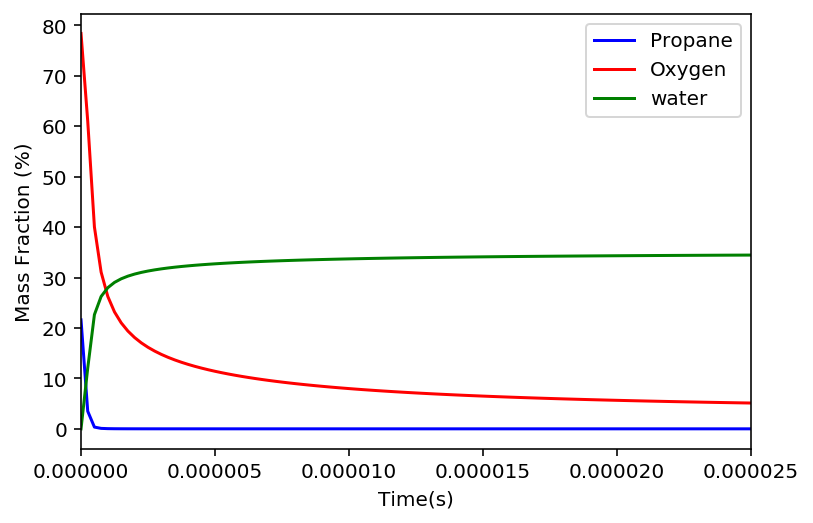

In [21]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(mod, mole_frac[:,speciesindices['CCC']] * 100, color="b" , label = 'Propane')
plt.plot(mod, mole_frac[:,speciesindices['O=O']] * 100, color="r" , label = 'Oxygen')
plt.plot(mod, mole_frac[:,speciesindices['O']] *100, color="g" , label = 'water')

#plt.ylim(0,100)
plt.xlim(0,0.000025)
plt.legend()
# plt.xlabel('Time(s)')

plt.xlabel('Time(s)')
plt.ylabel('Mass Fraction (%)')
#plt.yscale('log')

## Optimization of rate parameters

To optimize rate parameters, one needs to get define the output measures to optimize and the associated rate constants. Here, we will optimize against the concentrations of three major species namely propane, oxygne and water.

In [22]:
# optimized species
opt_species = ['CCC', 'O=O', 'O']

# rate parameters to optimize
sensitive_reac = [  1,  19,  22,  23,  89,  90, 219, 230, 236, 239, 242, 243]

Here, we will optimize all the three Arrhenius rate parameters(**A**, **Ea** and **n**) for the above reactions. You can read the initial estimations of these rate parameters from a file, but here we are randomizining them and varying $\pm$20% from their base value.

In [23]:
forward_rate_val = forward_rate_constants_all[0].copy()
forward_rate_params = forward_rate_constants_all[1].copy()
import random
initial_guess = np.array([random.uniform(0.8, 1.2) for i in range (len(sensitive_reac)*3)])
initial_guess = initial_guess.reshape(len(sensitive_reac), 3)

To be more reasonable, we will vary the value of _lnA_ instead of _A_ by $\pm$20% and store the new forward rate parameter values in a variable 

In [24]:
forward_rate_params[:,0] = np.log(forward_rate_params[:,0])

for i,number in enumerate(sensitive_reac):
    forward_rate_params[number] = np.multiply(forward_rate_params[number], initial_guess[i])
 

In [25]:
forward_rate_val= [np.exp(a[0]) * temp ** a[1] * np.exp((- a[2]) * 4.184 / (GAS_CONST * temp))
                   for a in forward_rate_params]

forward_rate_constants_new = forward_rate_val, forward_rate_params


### Here comes the optimization part, we need to define some variables to do so

In [27]:
# define the cost function, usually RMSE
cost_func = 'rmse'

# list the algorithms to perform optimization, there are 10 of them
#algorithms = ['mle', 'mcmc', 'sa', 'dds']
algorithms = ['mc']
#algorithms = ['mc', 'lhs', 'mle', 'mcmc', 'sceua', 'sa', 'rope', 'abc', 'fscabc', 'dds']

# time
t_final = 2.5e-5

# define range of parameters [low, high, max_step, initial]
ini_value = [0.8, 1.25, 0.02, 0.99]

# declare a list to store results
results = []

# number of iterations
rep = 100

# parallel of sequential solver for optimization
parallel = "seq"

# database format, should be custom
dbformat = "custom"

# number of processes to run
processes = len(algorithms)

Once you have defined all the parameters for optimization, now you can optimize your model parallely for all the different algorithms.

In [28]:
from kinexns.optimize import *
import time 

tic = time.time()

multi_optimization(processes, rep, sensitive_reac, 'params',
                       speciesindices, ini_value, sim, cost_func, forward_rate_constants_new,
                       file_rateconstant_list, file_thermo, stoic_matrix, unique_species, y0,
                       t_final, algorithms, temp, opt_species, third_body=third_body_matrix, factor=1,
                       chemkin_data=data_from_chemkin, smiles=smiles_dict, energy_conv='cal')

toc = time.time()
print(toc-tic)

1
Initializing the  Monte Carlo (MC) sampler  with  100  repetitions
Starting the MC algorithm with 100 repetitions...
[ 4.53119807e+04  9.18924050e+01 -4.97058968e+04  4.97977892e+04
 -3.36619643e+05 -3.86325539e+05 -3.81839731e+05 -3.36527750e+05
 -1.58752572e+05 -1.13440591e+05 -1.77775178e+05 -2.23179052e+05
 -2.27572968e+05 -2.23087159e+05 -2.72884948e+05 -7.99510677e+04
 -1.44285655e+05 -7.88933965e+04 -3.06374472e+05 -1.28599293e+05
 -7.88015041e+04 -3.90839064e+05 -5.43113141e+04 -2.32086493e+05
 -8.99933334e+03 -2.37798791e+04 -3.60399522e+05 -3.60307629e+05
 -4.14618943e+05 -4.10105419e+05 -1.37220470e+05 -3.38178062e+05
 -2.46916626e+05 -8.97030164e+04 -8.96111240e+04 -1.39408913e+05
  1.33476035e+05 -1.08096199e+04 -2.22214601e+04 -7.19273569e+04
 -2.21295676e+04  2.00957592e+05  5.66719364e+04  1.09890657e+04
  5.41658513e+04  4.45995452e+03 -2.65175729e+05 -2.16190158e+05
 -9.68837325e+04 -2.19863749e+05  1.26203427e+05 -2.05201092e+05
  6.74382139e+04 -3.14398183e+05 -2.

  1.38931275e+04 -6.99756461e+04 -2.34472819e+05 -4.13351411e+04]
Final Run Statistics: --- 

 Number of steps                                 : 1102
 Number of function evaluations                  : 1854
 Number of Jacobian evaluations                  : 29
 Number of function eval. due to Jacobian eval.  : 1334
 Number of error test failures                   : 87
 Number of nonlinear iterations                  : 1851
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 2.5e-05 seconds.
Elapsed simulation time: 0.9411723330000541 seconds.
2 of 100, min objf=-18.263, max objf=-6.47886, time remaining: 00:01:15
[ 4.53119807e+04  9.18924050e+01 -4.97058968e+04  4.97977892e+04
 -3.36619643e+05 -3.86325539e+0

  1.38931275e+04 -6.99756461e+04 -2.34472819e+05 -4.13351411e+04]
Final Run Statistics: --- 

 Number of steps                                 : 1311
 Number of function evaluations                  : 2220
 Number of Jacobian evaluations                  : 34
 Number of function eval. due to Jacobian eval.  : 1564
 Number of error test failures                   : 103
 Number of nonlinear iterations                  : 2217
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 2.5e-05 seconds.
Elapsed simulation time: 1.1816254729999969 seconds.
4 of 100, min objf=-187.185, max objf=-6.47886, time remaining: 00:01:32
[ 4.53119807e+04  9.18924050e+01 -4.97058968e+04  4.97977892e+04
 -3.36619643e+05 -3.86325539e

  1.38931275e+04 -6.99756461e+04 -2.34472819e+05 -4.13351411e+04]
Final Run Statistics: --- 

 Number of steps                                 : 1132
 Number of function evaluations                  : 1815
 Number of Jacobian evaluations                  : 26
 Number of function eval. due to Jacobian eval.  : 1196
 Number of error test failures                   : 88
 Number of nonlinear iterations                  : 1812
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 2.5e-05 seconds.
Elapsed simulation time: 0.9448108130000037 seconds.
6 of 100, min objf=-187.185, max objf=-5.98188, time remaining: 00:01:36
[ 4.53119807e+04  9.18924050e+01 -4.97058968e+04  4.97977892e+04
 -3.36619643e+05 -3.86325539e+

  1.38931275e+04 -6.99756461e+04 -2.34472819e+05 -4.13351411e+04]
Final Run Statistics: --- 

 Number of steps                                 : 1334
 Number of function evaluations                  : 2250
 Number of Jacobian evaluations                  : 41
 Number of function eval. due to Jacobian eval.  : 1886
 Number of error test failures                   : 86
 Number of nonlinear iterations                  : 2247
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 2.5e-05 seconds.
Elapsed simulation time: 1.259909537999988 seconds.
8 of 100, min objf=-703.635, max objf=-5.98188, time remaining: 00:01:39
[ 4.53119807e+04  9.18924050e+01 -4.97058968e+04  4.97977892e+04
 -3.36619643e+05 -3.86325539e+0

  1.38931275e+04 -6.99756461e+04 -2.34472819e+05 -4.13351411e+04]
Final Run Statistics: --- 

 Number of steps                                 : 1014
 Number of function evaluations                  : 1807
 Number of Jacobian evaluations                  : 37
 Number of function eval. due to Jacobian eval.  : 1702
 Number of error test failures                   : 87
 Number of nonlinear iterations                  : 1804
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 2.5e-05 seconds.
Elapsed simulation time: 1.0315549170000509 seconds.
10 of 100, min objf=-703.635, max objf=-5.98188, time remaining: 00:01:41
[ 4.53119807e+04  9.18924050e+01 -4.97058968e+04  4.97977892e+04
 -3.36619643e+05 -3.86325539e

  1.38931275e+04 -6.99756461e+04 -2.34472819e+05 -4.13351411e+04]
Final Run Statistics: --- 

 Number of steps                                 : 1130
 Number of function evaluations                  : 1847
 Number of Jacobian evaluations                  : 32
 Number of function eval. due to Jacobian eval.  : 1472
 Number of error test failures                   : 78
 Number of nonlinear iterations                  : 1844
 Number of nonlinear convergence failures        : 1

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 2.5e-05 seconds.
Elapsed simulation time: 1.1078334260000133 seconds.
12 of 100, min objf=-703.635, max objf=-5.98188, time remaining: 00:01:37
[ 4.53119807e+04  9.18924050e+01 -4.97058968e+04  4.97977892e+04
 -3.36619643e+05 -3.86325539e

  1.38931275e+04 -6.99756461e+04 -2.34472819e+05 -4.13351411e+04]
Final Run Statistics: --- 

 Number of steps                                 : 1126
 Number of function evaluations                  : 1911
 Number of Jacobian evaluations                  : 29
 Number of function eval. due to Jacobian eval.  : 1334
 Number of error test failures                   : 93
 Number of nonlinear iterations                  : 1908
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 2.5e-05 seconds.
Elapsed simulation time: 0.9200954529999876 seconds.
[ 4.53119807e+04  9.18924050e+01 -4.97058968e+04  4.97977892e+04
 -3.36619643e+05 -3.86325539e+05 -3.81839731e+05 -3.36527750e+05
 -1.58752572e+05 -1.13440591e+05 -1.77

  1.38931275e+04 -6.99756461e+04 -2.34472819e+05 -4.13351411e+04]
Final Run Statistics: --- 

 Number of steps                                 : 985
 Number of function evaluations                  : 1581
 Number of Jacobian evaluations                  : 25
 Number of function eval. due to Jacobian eval.  : 1150
 Number of error test failures                   : 66
 Number of nonlinear iterations                  : 1578
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 2.5e-05 seconds.
Elapsed simulation time: 0.7693222519999949 seconds.
[ 4.53119807e+04  9.18924050e+01 -4.97058968e+04  4.97977892e+04
 -3.36619643e+05 -3.86325539e+05 -3.81839731e+05 -3.36527750e+05
 -1.58752572e+05 -1.13440591e+05 -1.777

  1.38931275e+04 -6.99756461e+04 -2.34472819e+05 -4.13351411e+04]
Final Run Statistics: --- 

 Number of steps                                 : 1557
 Number of function evaluations                  : 2577
 Number of Jacobian evaluations                  : 44
 Number of function eval. due to Jacobian eval.  : 2024
 Number of error test failures                   : 115
 Number of nonlinear iterations                  : 2574
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 2.5e-05 seconds.
Elapsed simulation time: 1.3140618670000208 seconds.
18 of 100, min objf=-703.635, max objf=-5.98188, time remaining: 00:01:27
[ 4.53119807e+04  9.18924050e+01 -4.97058968e+04  4.97977892e+04
 -3.36619643e+05 -3.86325539

  1.38931275e+04 -6.99756461e+04 -2.34472819e+05 -4.13351411e+04]
Final Run Statistics: --- 

 Number of steps                                 : 839
 Number of function evaluations                  : 1442
 Number of Jacobian evaluations                  : 19
 Number of function eval. due to Jacobian eval.  : 874
 Number of error test failures                   : 59
 Number of nonlinear iterations                  : 1439
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 2.5e-05 seconds.
Elapsed simulation time: 0.6594847750000099 seconds.
[ 4.53119807e+04  9.18924050e+01 -4.97058968e+04  4.97977892e+04
 -3.36619643e+05 -3.86325539e+05 -3.81839731e+05 -3.36527750e+05
 -1.58752572e+05 -1.13440591e+05 -1.7777

  1.38931275e+04 -6.99756461e+04 -2.34472819e+05 -4.13351411e+04]
Final Run Statistics: --- 

 Number of steps                                 : 1281
 Number of function evaluations                  : 2022
 Number of Jacobian evaluations                  : 31
 Number of function eval. due to Jacobian eval.  : 1426
 Number of error test failures                   : 81
 Number of nonlinear iterations                  : 2019
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 2.5e-05 seconds.
Elapsed simulation time: 0.9719963269999994 seconds.
[ 4.53119807e+04  9.18924050e+01 -4.97058968e+04  4.97977892e+04
 -3.36619643e+05 -3.86325539e+05 -3.81839731e+05 -3.36527750e+05
 -1.58752572e+05 -1.13440591e+05 -1.77

  1.38931275e+04 -6.99756461e+04 -2.34472819e+05 -4.13351411e+04]
Final Run Statistics: --- 

 Number of steps                                 : 1212
 Number of function evaluations                  : 1957
 Number of Jacobian evaluations                  : 30
 Number of function eval. due to Jacobian eval.  : 1380
 Number of error test failures                   : 86
 Number of nonlinear iterations                  : 1954
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 2.5e-05 seconds.
Elapsed simulation time: 0.9371546689999946 seconds.
[ 4.53119807e+04  9.18924050e+01 -4.97058968e+04  4.97977892e+04
 -3.36619643e+05 -3.86325539e+05 -3.81839731e+05 -3.36527750e+05
 -1.58752572e+05 -1.13440591e+05 -1.77

  1.38931275e+04 -6.99756461e+04 -2.34472819e+05 -4.13351411e+04]
Final Run Statistics: --- 

 Number of steps                                 : 1024
 Number of function evaluations                  : 1688
 Number of Jacobian evaluations                  : 26
 Number of function eval. due to Jacobian eval.  : 1196
 Number of error test failures                   : 92
 Number of nonlinear iterations                  : 1685
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 2.5e-05 seconds.
Elapsed simulation time: 0.8053163600000062 seconds.
[ 4.53119807e+04  9.18924050e+01 -4.97058968e+04  4.97977892e+04
 -3.36619643e+05 -3.86325539e+05 -3.81839731e+05 -3.36527750e+05
 -1.58752572e+05 -1.13440591e+05 -1.77

  1.38931275e+04 -6.99756461e+04 -2.34472819e+05 -4.13351411e+04]
Final Run Statistics: --- 

 Number of steps                                 : 1749
 Number of function evaluations                  : 2920
 Number of Jacobian evaluations                  : 56
 Number of function eval. due to Jacobian eval.  : 2576
 Number of error test failures                   : 119
 Number of nonlinear iterations                  : 2917
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 2.5e-05 seconds.
Elapsed simulation time: 1.5459667289999857 seconds.
28 of 100, min objf=-4339.75, max objf=-4.6663, time remaining: 00:01:16
[ 4.53119807e+04  9.18924050e+01 -4.97058968e+04  4.97977892e+04
 -3.36619643e+05 -3.86325539e

  1.38931275e+04 -6.99756461e+04 -2.34472819e+05 -4.13351411e+04]
Final Run Statistics: --- 

 Number of steps                                 : 1106
 Number of function evaluations                  : 2007
 Number of Jacobian evaluations                  : 38
 Number of function eval. due to Jacobian eval.  : 1748
 Number of error test failures                   : 93
 Number of nonlinear iterations                  : 2004
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 2.5e-05 seconds.
Elapsed simulation time: 1.1364686239999742 seconds.
30 of 100, min objf=-4339.75, max objf=-4.6663, time remaining: 00:01:14
[ 4.53119807e+04  9.18924050e+01 -4.97058968e+04  4.97977892e+04
 -3.36619643e+05 -3.86325539e+

  1.38931275e+04 -6.99756461e+04 -2.34472819e+05 -4.13351411e+04]
Final Run Statistics: --- 

 Number of steps                                 : 1033
 Number of function evaluations                  : 1699
 Number of Jacobian evaluations                  : 23
 Number of function eval. due to Jacobian eval.  : 1058
 Number of error test failures                   : 76
 Number of nonlinear iterations                  : 1696
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 2.5e-05 seconds.
Elapsed simulation time: 0.8072436059999859 seconds.
[ 4.53119807e+04  9.18924050e+01 -4.97058968e+04  4.97977892e+04
 -3.36619643e+05 -3.86325539e+05 -3.81839731e+05 -3.36527750e+05
 -1.58752572e+05 -1.13440591e+05 -1.77

  1.38931275e+04 -6.99756461e+04 -2.34472819e+05 -4.13351411e+04]
Final Run Statistics: --- 

 Number of steps                                 : 1234
 Number of function evaluations                  : 1991
 Number of Jacobian evaluations                  : 30
 Number of function eval. due to Jacobian eval.  : 1380
 Number of error test failures                   : 84
 Number of nonlinear iterations                  : 1988
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 2.5e-05 seconds.
Elapsed simulation time: 0.962146099999984 seconds.
[ 4.53119807e+04  9.18924050e+01 -4.97058968e+04  4.97977892e+04
 -3.36619643e+05 -3.86325539e+05 -3.81839731e+05 -3.36527750e+05
 -1.58752572e+05 -1.13440591e+05 -1.777

  1.38931275e+04 -6.99756461e+04 -2.34472819e+05 -4.13351411e+04]
Final Run Statistics: --- 

 Number of steps                                 : 1260
 Number of function evaluations                  : 2052
 Number of Jacobian evaluations                  : 36
 Number of function eval. due to Jacobian eval.  : 1656
 Number of error test failures                   : 93
 Number of nonlinear iterations                  : 2049
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 2.5e-05 seconds.
Elapsed simulation time: 1.0522300979999955 seconds.
[ 4.53119807e+04  9.18924050e+01 -4.97058968e+04  4.97977892e+04
 -3.36619643e+05 -3.86325539e+05 -3.81839731e+05 -3.36527750e+05
 -1.58752572e+05 -1.13440591e+05 -1.77

  1.38931275e+04 -6.99756461e+04 -2.34472819e+05 -4.13351411e+04]
Final Run Statistics: --- 

 Number of steps                                 : 1431
 Number of function evaluations                  : 2473
 Number of Jacobian evaluations                  : 44
 Number of function eval. due to Jacobian eval.  : 2024
 Number of error test failures                   : 119
 Number of nonlinear iterations                  : 2470
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 2.5e-05 seconds.
Elapsed simulation time: 1.2905239440000287 seconds.
[ 4.53119807e+04  9.18924050e+01 -4.97058968e+04  4.97977892e+04
 -3.36619643e+05 -3.86325539e+05 -3.81839731e+05 -3.36527750e+05
 -1.58752572e+05 -1.13440591e+05 -1.7

  1.38931275e+04 -6.99756461e+04 -2.34472819e+05 -4.13351411e+04]
Final Run Statistics: --- 

 Number of steps                                 : 1557
 Number of function evaluations                  : 2603
 Number of Jacobian evaluations                  : 44
 Number of function eval. due to Jacobian eval.  : 2024
 Number of error test failures                   : 121
 Number of nonlinear iterations                  : 2600
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 2.5e-05 seconds.
Elapsed simulation time: 1.3890998880000325 seconds.
[ 4.53119807e+04  9.18924050e+01 -4.97058968e+04  4.97977892e+04
 -3.36619643e+05 -3.86325539e+05 -3.81839731e+05 -3.36527750e+05
 -1.58752572e+05 -1.13440591e+05 -1.7

  1.38931275e+04 -6.99756461e+04 -2.34472819e+05 -4.13351411e+04]
Final Run Statistics: --- 

 Number of steps                                 : 1444
 Number of function evaluations                  : 2325
 Number of Jacobian evaluations                  : 37
 Number of function eval. due to Jacobian eval.  : 1702
 Number of error test failures                   : 134
 Number of nonlinear iterations                  : 2322
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 2.5e-05 seconds.
Elapsed simulation time: 1.2370235439999533 seconds.
[ 4.53119807e+04  9.18924050e+01 -4.97058968e+04  4.97977892e+04
 -3.36619643e+05 -3.86325539e+05 -3.81839731e+05 -3.36527750e+05
 -1.58752572e+05 -1.13440591e+05 -1.7

  1.38931275e+04 -6.99756461e+04 -2.34472819e+05 -4.13351411e+04]
Final Run Statistics: --- 

 Number of steps                                 : 1349
 Number of function evaluations                  : 2197
 Number of Jacobian evaluations                  : 36
 Number of function eval. due to Jacobian eval.  : 1656
 Number of error test failures                   : 91
 Number of nonlinear iterations                  : 2194
 Number of nonlinear convergence failures        : 2

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 2.5e-05 seconds.
Elapsed simulation time: 1.1464941129999602 seconds.
[ 4.53119807e+04  9.18924050e+01 -4.97058968e+04  4.97977892e+04
 -3.36619643e+05 -3.86325539e+05 -3.81839731e+05 -3.36527750e+05
 -1.58752572e+05 -1.13440591e+05 -1.77

  1.38931275e+04 -6.99756461e+04 -2.34472819e+05 -4.13351411e+04]
Final Run Statistics: --- 

 Number of steps                                 : 1471
 Number of function evaluations                  : 2437
 Number of Jacobian evaluations                  : 32
 Number of function eval. due to Jacobian eval.  : 1472
 Number of error test failures                   : 117
 Number of nonlinear iterations                  : 2434
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 2.5e-05 seconds.
Elapsed simulation time: 1.227076846999978 seconds.
[ 4.53119807e+04  9.18924050e+01 -4.97058968e+04  4.97977892e+04
 -3.36619643e+05 -3.86325539e+05 -3.81839731e+05 -3.36527750e+05
 -1.58752572e+05 -1.13440591e+05 -1.77

  1.38931275e+04 -6.99756461e+04 -2.34472819e+05 -4.13351411e+04]
Final Run Statistics: --- 

 Number of steps                                 : 1829
 Number of function evaluations                  : 3073
 Number of Jacobian evaluations                  : 52
 Number of function eval. due to Jacobian eval.  : 2392
 Number of error test failures                   : 151
 Number of nonlinear iterations                  : 3070
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 2.5e-05 seconds.
Elapsed simulation time: 1.694309120000014 seconds.
[ 4.53119807e+04  9.18924050e+01 -4.97058968e+04  4.97977892e+04
 -3.36619643e+05 -3.86325539e+05 -3.81839731e+05 -3.36527750e+05
 -1.58752572e+05 -1.13440591e+05 -1.77

  1.38931275e+04 -6.99756461e+04 -2.34472819e+05 -4.13351411e+04]
Final Run Statistics: --- 

 Number of steps                                 : 1230
 Number of function evaluations                  : 1999
 Number of Jacobian evaluations                  : 35
 Number of function eval. due to Jacobian eval.  : 1610
 Number of error test failures                   : 86
 Number of nonlinear iterations                  : 1996
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 2.5e-05 seconds.
Elapsed simulation time: 1.1871460770000226 seconds.
[ 4.53119807e+04  9.18924050e+01 -4.97058968e+04  4.97977892e+04
 -3.36619643e+05 -3.86325539e+05 -3.81839731e+05 -3.36527750e+05
 -1.58752572e+05 -1.13440591e+05 -1.77

  1.38931275e+04 -6.99756461e+04 -2.34472819e+05 -4.13351411e+04]
Final Run Statistics: --- 

 Number of steps                                 : 1117
 Number of function evaluations                  : 1954
 Number of Jacobian evaluations                  : 39
 Number of function eval. due to Jacobian eval.  : 1794
 Number of error test failures                   : 83
 Number of nonlinear iterations                  : 1951
 Number of nonlinear convergence failures        : 3

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 2.5e-05 seconds.
Elapsed simulation time: 1.0987292419999903 seconds.
[ 4.53119807e+04  9.18924050e+01 -4.97058968e+04  4.97977892e+04
 -3.36619643e+05 -3.86325539e+05 -3.81839731e+05 -3.36527750e+05
 -1.58752572e+05 -1.13440591e+05 -1.77

  1.38931275e+04 -6.99756461e+04 -2.34472819e+05 -4.13351411e+04]
Final Run Statistics: --- 

 Number of steps                                 : 1253
 Number of function evaluations                  : 2033
 Number of Jacobian evaluations                  : 29
 Number of function eval. due to Jacobian eval.  : 1334
 Number of error test failures                   : 89
 Number of nonlinear iterations                  : 2030
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 2.5e-05 seconds.
Elapsed simulation time: 0.9869963680000069 seconds.
54 of 100, min objf=-4339.75, max objf=-4.6663, time remaining: 00:00:51
[ 4.53119807e+04  9.18924050e+01 -4.97058968e+04  4.97977892e+04
 -3.36619643e+05 -3.86325539e+

  1.38931275e+04 -6.99756461e+04 -2.34472819e+05 -4.13351411e+04]
Final Run Statistics: --- 

 Number of steps                                 : 1023
 Number of function evaluations                  : 1756
 Number of Jacobian evaluations                  : 23
 Number of function eval. due to Jacobian eval.  : 1058
 Number of error test failures                   : 85
 Number of nonlinear iterations                  : 1753
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 2.5e-05 seconds.
Elapsed simulation time: 0.8228907259999687 seconds.
56 of 100, min objf=-4339.75, max objf=-4.6663, time remaining: 00:00:49
[ 4.53119807e+04  9.18924050e+01 -4.97058968e+04  4.97977892e+04
 -3.36619643e+05 -3.86325539e+

  1.38931275e+04 -6.99756461e+04 -2.34472819e+05 -4.13351411e+04]
Final Run Statistics: --- 

 Number of steps                                 : 965
 Number of function evaluations                  : 1577
 Number of Jacobian evaluations                  : 25
 Number of function eval. due to Jacobian eval.  : 1150
 Number of error test failures                   : 65
 Number of nonlinear iterations                  : 1574
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 2.5e-05 seconds.
Elapsed simulation time: 0.7994110070000033 seconds.
[ 4.53119807e+04  9.18924050e+01 -4.97058968e+04  4.97977892e+04
 -3.36619643e+05 -3.86325539e+05 -3.81839731e+05 -3.36527750e+05
 -1.58752572e+05 -1.13440591e+05 -1.777

  1.38931275e+04 -6.99756461e+04 -2.34472819e+05 -4.13351411e+04]
Final Run Statistics: --- 

 Number of steps                                 : 971
 Number of function evaluations                  : 1490
 Number of Jacobian evaluations                  : 24
 Number of function eval. due to Jacobian eval.  : 1104
 Number of error test failures                   : 41
 Number of nonlinear iterations                  : 1487
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 2.5e-05 seconds.
Elapsed simulation time: 0.7438400030000025 seconds.
[ 4.53119807e+04  9.18924050e+01 -4.97058968e+04  4.97977892e+04
 -3.36619643e+05 -3.86325539e+05 -3.81839731e+05 -3.36527750e+05
 -1.58752572e+05 -1.13440591e+05 -1.777

  1.38931275e+04 -6.99756461e+04 -2.34472819e+05 -4.13351411e+04]
Final Run Statistics: --- 

 Number of steps                                 : 1127
 Number of function evaluations                  : 1825
 Number of Jacobian evaluations                  : 26
 Number of function eval. due to Jacobian eval.  : 1196
 Number of error test failures                   : 79
 Number of nonlinear iterations                  : 1822
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 2.5e-05 seconds.
Elapsed simulation time: 0.8831616240000244 seconds.
62 of 100, min objf=-4339.75, max objf=-4.6663, time remaining: 00:00:42
[ 4.53119807e+04  9.18924050e+01 -4.97058968e+04  4.97977892e+04
 -3.36619643e+05 -3.86325539e+

  1.38931275e+04 -6.99756461e+04 -2.34472819e+05 -4.13351411e+04]
Final Run Statistics: --- 

 Number of steps                                 : 1275
 Number of function evaluations                  : 2133
 Number of Jacobian evaluations                  : 32
 Number of function eval. due to Jacobian eval.  : 1472
 Number of error test failures                   : 109
 Number of nonlinear iterations                  : 2130
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 2.5e-05 seconds.
Elapsed simulation time: 1.0643102890000478 seconds.
64 of 100, min objf=-4339.75, max objf=-4.6663, time remaining: 00:00:39
[ 4.53119807e+04  9.18924050e+01 -4.97058968e+04  4.97977892e+04
 -3.36619643e+05 -3.86325539e

  1.38931275e+04 -6.99756461e+04 -2.34472819e+05 -4.13351411e+04]
Final Run Statistics: --- 

 Number of steps                                 : 1433
 Number of function evaluations                  : 2314
 Number of Jacobian evaluations                  : 37
 Number of function eval. due to Jacobian eval.  : 1702
 Number of error test failures                   : 96
 Number of nonlinear iterations                  : 2311
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 2.5e-05 seconds.
Elapsed simulation time: 1.1655218330000139 seconds.
66 of 100, min objf=-4339.75, max objf=-4.6663, time remaining: 00:00:37
[ 4.53119807e+04  9.18924050e+01 -4.97058968e+04  4.97977892e+04
 -3.36619643e+05 -3.86325539e+

  1.38931275e+04 -6.99756461e+04 -2.34472819e+05 -4.13351411e+04]
Final Run Statistics: --- 

 Number of steps                                 : 1323
 Number of function evaluations                  : 2227
 Number of Jacobian evaluations                  : 37
 Number of function eval. due to Jacobian eval.  : 1702
 Number of error test failures                   : 102
 Number of nonlinear iterations                  : 2224
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 2.5e-05 seconds.
Elapsed simulation time: 1.2716197749999765 seconds.
68 of 100, min objf=-4339.75, max objf=-4.6663, time remaining: 00:00:35
[ 4.53119807e+04  9.18924050e+01 -4.97058968e+04  4.97977892e+04
 -3.36619643e+05 -3.86325539e

  1.38931275e+04 -6.99756461e+04 -2.34472819e+05 -4.13351411e+04]
Final Run Statistics: --- 

 Number of steps                                 : 1154
 Number of function evaluations                  : 1781
 Number of Jacobian evaluations                  : 28
 Number of function eval. due to Jacobian eval.  : 1288
 Number of error test failures                   : 76
 Number of nonlinear iterations                  : 1778
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 2.5e-05 seconds.
Elapsed simulation time: 1.0229768730000046 seconds.
[ 4.53119807e+04  9.18924050e+01 -4.97058968e+04  4.97977892e+04
 -3.36619643e+05 -3.86325539e+05 -3.81839731e+05 -3.36527750e+05
 -1.58752572e+05 -1.13440591e+05 -1.77

  1.38931275e+04 -6.99756461e+04 -2.34472819e+05 -4.13351411e+04]
Final Run Statistics: --- 

 Number of steps                                 : 1457
 Number of function evaluations                  : 2429
 Number of Jacobian evaluations                  : 39
 Number of function eval. due to Jacobian eval.  : 1794
 Number of error test failures                   : 120
 Number of nonlinear iterations                  : 2426
 Number of nonlinear convergence failures        : 1

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 2.5e-05 seconds.
Elapsed simulation time: 1.4090296990000297 seconds.
[ 4.53119807e+04  9.18924050e+01 -4.97058968e+04  4.97977892e+04
 -3.36619643e+05 -3.86325539e+05 -3.81839731e+05 -3.36527750e+05
 -1.58752572e+05 -1.13440591e+05 -1.7

  1.38931275e+04 -6.99756461e+04 -2.34472819e+05 -4.13351411e+04]
Final Run Statistics: --- 

 Number of steps                                 : 940
 Number of function evaluations                  : 1625
 Number of Jacobian evaluations                  : 26
 Number of function eval. due to Jacobian eval.  : 1196
 Number of error test failures                   : 56
 Number of nonlinear iterations                  : 1622
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 2.5e-05 seconds.
Elapsed simulation time: 0.8214891089999696 seconds.
[ 4.53119807e+04  9.18924050e+01 -4.97058968e+04  4.97977892e+04
 -3.36619643e+05 -3.86325539e+05 -3.81839731e+05 -3.36527750e+05
 -1.58752572e+05 -1.13440591e+05 -1.777

  1.38931275e+04 -6.99756461e+04 -2.34472819e+05 -4.13351411e+04]
Final Run Statistics: --- 

 Number of steps                                 : 1126
 Number of function evaluations                  : 1872
 Number of Jacobian evaluations                  : 30
 Number of function eval. due to Jacobian eval.  : 1380
 Number of error test failures                   : 89
 Number of nonlinear iterations                  : 1869
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 2.5e-05 seconds.
Elapsed simulation time: 0.9543689180000001 seconds.
[ 4.53119807e+04  9.18924050e+01 -4.97058968e+04  4.97977892e+04
 -3.36619643e+05 -3.86325539e+05 -3.81839731e+05 -3.36527750e+05
 -1.58752572e+05 -1.13440591e+05 -1.77

  1.38931275e+04 -6.99756461e+04 -2.34472819e+05 -4.13351411e+04]
Final Run Statistics: --- 

 Number of steps                                 : 1101
 Number of function evaluations                  : 1848
 Number of Jacobian evaluations                  : 34
 Number of function eval. due to Jacobian eval.  : 1564
 Number of error test failures                   : 74
 Number of nonlinear iterations                  : 1845
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 2.5e-05 seconds.
Elapsed simulation time: 0.9651658590000238 seconds.
[ 4.53119807e+04  9.18924050e+01 -4.97058968e+04  4.97977892e+04
 -3.36619643e+05 -3.86325539e+05 -3.81839731e+05 -3.36527750e+05
 -1.58752572e+05 -1.13440591e+05 -1.77

  1.38931275e+04 -6.99756461e+04 -2.34472819e+05 -4.13351411e+04]
Final Run Statistics: --- 

 Number of steps                                 : 1870
 Number of function evaluations                  : 3049
 Number of Jacobian evaluations                  : 52
 Number of function eval. due to Jacobian eval.  : 2392
 Number of error test failures                   : 142
 Number of nonlinear iterations                  : 3046
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 2.5e-05 seconds.
Elapsed simulation time: 1.6081226410000227 seconds.
80 of 100, min objf=-4339.75, max objf=-4.6663, time remaining: 00:00:22
[ 4.53119807e+04  9.18924050e+01 -4.97058968e+04  4.97977892e+04
 -3.36619643e+05 -3.86325539e

  1.38931275e+04 -6.99756461e+04 -2.34472819e+05 -4.13351411e+04]
Final Run Statistics: --- 

 Number of steps                                 : 1352
 Number of function evaluations                  : 2184
 Number of Jacobian evaluations                  : 40
 Number of function eval. due to Jacobian eval.  : 1840
 Number of error test failures                   : 83
 Number of nonlinear iterations                  : 2181
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 2.5e-05 seconds.
Elapsed simulation time: 1.1753273360000094 seconds.
82 of 100, min objf=-4339.75, max objf=-4.6663, time remaining: 00:00:19
[ 4.53119807e+04  9.18924050e+01 -4.97058968e+04  4.97977892e+04
 -3.36619643e+05 -3.86325539e+

  1.38931275e+04 -6.99756461e+04 -2.34472819e+05 -4.13351411e+04]
Final Run Statistics: --- 

 Number of steps                                 : 1272
 Number of function evaluations                  : 2119
 Number of Jacobian evaluations                  : 37
 Number of function eval. due to Jacobian eval.  : 1702
 Number of error test failures                   : 82
 Number of nonlinear iterations                  : 2116
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 2.5e-05 seconds.
Elapsed simulation time: 1.1198206890000506 seconds.
84 of 100, min objf=-4339.75, max objf=-4.6663, time remaining: 00:00:17
[ 4.53119807e+04  9.18924050e+01 -4.97058968e+04  4.97977892e+04
 -3.36619643e+05 -3.86325539e+

  1.38931275e+04 -6.99756461e+04 -2.34472819e+05 -4.13351411e+04]
Final Run Statistics: --- 

 Number of steps                                 : 1182
 Number of function evaluations                  : 1943
 Number of Jacobian evaluations                  : 29
 Number of function eval. due to Jacobian eval.  : 1334
 Number of error test failures                   : 90
 Number of nonlinear iterations                  : 1940
 Number of nonlinear convergence failures        : 1

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 2.5e-05 seconds.
Elapsed simulation time: 1.0283274159999678 seconds.
86 of 100, min objf=-4339.75, max objf=-4.6663, time remaining: 00:00:15
[ 4.53119807e+04  9.18924050e+01 -4.97058968e+04  4.97977892e+04
 -3.36619643e+05 -3.86325539e+

  1.38931275e+04 -6.99756461e+04 -2.34472819e+05 -4.13351411e+04]
Final Run Statistics: --- 

 Number of steps                                 : 1233
 Number of function evaluations                  : 2032
 Number of Jacobian evaluations                  : 28
 Number of function eval. due to Jacobian eval.  : 1288
 Number of error test failures                   : 95
 Number of nonlinear iterations                  : 2029
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 2.5e-05 seconds.
Elapsed simulation time: 0.9884988579999572 seconds.
[ 4.53119807e+04  9.18924050e+01 -4.97058968e+04  4.97977892e+04
 -3.36619643e+05 -3.86325539e+05 -3.81839731e+05 -3.36527750e+05
 -1.58752572e+05 -1.13440591e+05 -1.77

  1.38931275e+04 -6.99756461e+04 -2.34472819e+05 -4.13351411e+04]
Final Run Statistics: --- 

 Number of steps                                 : 1060
 Number of function evaluations                  : 1648
 Number of Jacobian evaluations                  : 25
 Number of function eval. due to Jacobian eval.  : 1150
 Number of error test failures                   : 55
 Number of nonlinear iterations                  : 1645
 Number of nonlinear convergence failures        : 1

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 2.5e-05 seconds.
Elapsed simulation time: 0.8860268039999823 seconds.
[ 4.53119807e+04  9.18924050e+01 -4.97058968e+04  4.97977892e+04
 -3.36619643e+05 -3.86325539e+05 -3.81839731e+05 -3.36527750e+05
 -1.58752572e+05 -1.13440591e+05 -1.77

  1.38931275e+04 -6.99756461e+04 -2.34472819e+05 -4.13351411e+04]
Final Run Statistics: --- 

 Number of steps                                 : 1183
 Number of function evaluations                  : 2012
 Number of Jacobian evaluations                  : 27
 Number of function eval. due to Jacobian eval.  : 1242
 Number of error test failures                   : 91
 Number of nonlinear iterations                  : 2009
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 2.5e-05 seconds.
Elapsed simulation time: 0.9453190920000338 seconds.
92 of 100, min objf=-4339.75, max objf=-4.6663, time remaining: 00:00:08
[ 4.53119807e+04  9.18924050e+01 -4.97058968e+04  4.97977892e+04
 -3.36619643e+05 -3.86325539e+

  1.38931275e+04 -6.99756461e+04 -2.34472819e+05 -4.13351411e+04]
Final Run Statistics: --- 

 Number of steps                                 : 1101
 Number of function evaluations                  : 1819
 Number of Jacobian evaluations                  : 32
 Number of function eval. due to Jacobian eval.  : 1472
 Number of error test failures                   : 64
 Number of nonlinear iterations                  : 1816
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 2.5e-05 seconds.
Elapsed simulation time: 0.9595251640000129 seconds.
94 of 100, min objf=-4339.75, max objf=-4.6663, time remaining: 00:00:06
[ 4.53119807e+04  9.18924050e+01 -4.97058968e+04  4.97977892e+04
 -3.36619643e+05 -3.86325539e+

  1.38931275e+04 -6.99756461e+04 -2.34472819e+05 -4.13351411e+04]
Final Run Statistics: --- 

 Number of steps                                 : 1501
 Number of function evaluations                  : 2654
 Number of Jacobian evaluations                  : 42
 Number of function eval. due to Jacobian eval.  : 1932
 Number of error test failures                   : 122
 Number of nonlinear iterations                  : 2651
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 2.5e-05 seconds.
Elapsed simulation time: 1.3227330700000266 seconds.
96 of 100, min objf=-4339.75, max objf=-4.6663, time remaining: 00:00:03
[ 4.53119807e+04  9.18924050e+01 -4.97058968e+04  4.97977892e+04
 -3.36619643e+05 -3.86325539e

  1.38931275e+04 -6.99756461e+04 -2.34472819e+05 -4.13351411e+04]
Final Run Statistics: --- 

 Number of steps                                 : 1153
 Number of function evaluations                  : 1819
 Number of Jacobian evaluations                  : 26
 Number of function eval. due to Jacobian eval.  : 1196
 Number of error test failures                   : 74
 Number of nonlinear iterations                  : 1816
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 2.5e-05 seconds.
Elapsed simulation time: 0.9212330540000266 seconds.
98 of 100, min objf=-4339.75, max objf=-4.6663, time remaining: 00:00:01
[ 4.53119807e+04  9.18924050e+01 -4.97058968e+04  4.97977892e+04
 -3.36619643e+05 -3.86325539e+

  1.38931275e+04 -6.99756461e+04 -2.34472819e+05 -4.13351411e+04]
Final Run Statistics: --- 

 Number of steps                                 : 1423
 Number of function evaluations                  : 2400
 Number of Jacobian evaluations                  : 51
 Number of function eval. due to Jacobian eval.  : 2346
 Number of error test failures                   : 74
 Number of nonlinear iterations                  : 2397
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 2.5e-05 seconds.
Elapsed simulation time: 1.4145889360000297 seconds.
100 of 100, min objf=-4339.75, max objf=-4.6663, time remaining: 23:59:59

*** Final SPOTPY summary ***
Total Duration: 117.11 seconds
Total Repetitions: 100
Minimal ob

In [ ]:
x = sim.shape
x[1]

In [ ]:
sim22 = []
sim22.append(sim)

In [ ]:
np.shape(sim22)

In [ ]:
convet_val = { 'cal': CAL_JL, 'kcal': KCAL_JL, 'hartrees' : HT_JL, 'KJ': 1000, 'J' : 1}
energy_conv = 'cal'
convert = convet_val.get(energy_conv)
convert

In [ ]:
sim1 = sim.reshape(1, sim.shape)

In [ ]:
sim1.shape